#Setting working directory and file path

In [0]:
# Set path to your data file
path_to_file = 'data/creditcard.csv' 

#Code

##Imports

In [4]:
# Libraries to be used in the experiment

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

import torch

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Class Definitions for ANN

In [0]:
class Classifier(torch.nn.Module):
    def __init__(self, n_input=10, n_hidden = 20, n_output = 1,drop_prob=0.5):
        super().__init__()
        self.extractor1 = torch.nn.Linear(n_input, n_hidden)
        self.extractor2 = torch.nn.Linear(n_hidden, n_hidden)
        self.relu = torch.nn.ReLU()
        self.drop_out = torch.nn.Dropout(drop_prob)
        self.classifier = torch.nn.Linear(n_hidden, n_output)
        

    def forward(self, xb):
        x = self.relu(self.extractor1(xb))
        x = self.relu(self.extractor2(x))
        x = self.drop_out(x)
        return self.classifier(x).squeeze()

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [0]:
def train(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        count = 0
        loss = 0
        for xb, yb in train_dl:
          losses, nums = loss_batch(model, loss_func, xb, yb, opt)
          loss += losses*nums
          count+=nums
        train_loss.append(loss/count)


        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        validation_loss.append(val_loss)

        print(epoch, val_loss)

    return train_loss, validation_loss

In [0]:
#Normalizing function [Rescales values of an array to fit in [0,1]]
def mat_normalize(arr):
  arr = arr - arr.min()
  arr = arr / arr.max()
  return arr


## Data Processing 1

In [9]:
# Read the data file and checkout first few lines
data = pd.read_csv(path_to_file) 
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0.5, 1.0, 'Class Imbalance')

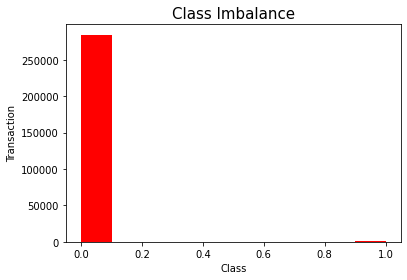

In [10]:
# Plot to visualize Imbalance in classes

plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)
#plt.show()

In [11]:
# To calculate the percentage of fraudulent transactions (0.17 %)
pc_fraud = len(data.loc[data['Class'] == 1].values)/len(data.loc[data['Class'] == 0].values)
print(pc_fraud*100)


0.17304750013189596


In [0]:
# Extracting Features and Targets
x = data.drop('Class', axis=1).values
y = data['Class'].values

In [0]:
# This is used to scale and translate each feature individually 
# such that it is in the given range on the training set (Normalization of features)
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)

In [0]:
# Train Test split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

In [15]:
print('Sampled train dataset shape %s' % Counter(ytrain))
print('Sampled validation dataset shape %s' % Counter(ytest))

Sampled train dataset shape Counter({0: 227454, 1: 391})
Sampled validation dataset shape Counter({0: 56861, 1: 101})


## CMTNN

### Truth Network

In [0]:
# Creating Torch dataset for training Truth NN
train_ds_tnn = torch.utils.data.TensorDataset(torch.tensor(xtrain).float(), torch.tensor(ytrain).float())
valid_ds_tnn = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest).float())


In [0]:
# Creating Torch dataloader for training Truth NN
bs =128 # Batch Size
train_dl_tnn = torch.utils.data.DataLoader(train_ds_tnn, batch_size=bs)
valid_dl_tnn = torch.utils.data.DataLoader(valid_ds_tnn, batch_size=bs)


In [0]:
# Static Model Parameters
n_input = xtrain.shape[1]
n_output = 1
n_hidden = 20

In [0]:
# Initializing the Truth NN model
TNN = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

In [0]:
# Static Training Parameters
lr = 0.001   # Learning Rate
pos_weight = torch.tensor([5])  # weight adjustment for class imbalance
opt = torch.optim.SGD(TNN.parameters(), lr=lr, momentum=0.9) #Optimizer
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)  #Loss function
#loss_func = torch.nn.BCELoss()
n_epoch = 50  # No. of epochs to run training

In [21]:
# Start Training
train_loss_tnn, val_loss_tnn = train(n_epoch,TNN,loss_func,opt,train_dl_tnn,valid_dl_tnn)


0 0.0482750040339409
1 0.04759915282454142
2 0.04701482716840931
3 0.04643754604002477
4 0.04583789178785248
5 0.045051558843711585
6 0.044022384744142364
7 0.04282065441315355
8 0.041283419893923146
9 0.03937558996631776
10 0.03688496749290007
11 0.03463448439206615
12 0.03247278550171684
13 0.030330706398614585
14 0.028222693294199876
15 0.02615207182147656
16 0.02422654045808056
17 0.02243258388063127
18 0.020731760291025917
19 0.019089614470007295
20 0.01757920768517029
21 0.01642979234001835
22 0.015458893640536672
23 0.014671897628468822
24 0.013911210595127873
25 0.013391950329612184
26 0.01299018236223447
27 0.012665243310220313
28 0.012456327480574361
29 0.012152244660598267
30 0.011955703075717897
31 0.011859552389268004
32 0.011691361783183335
33 0.01159728345685216
34 0.011525968468690253
35 0.011410988046125867
36 0.011444919567601885
37 0.011308482363660501
38 0.011270663202947406
39 0.011188155859012935
40 0.011128584204919762
41 0.011185763091490362
42 0.011221607957300

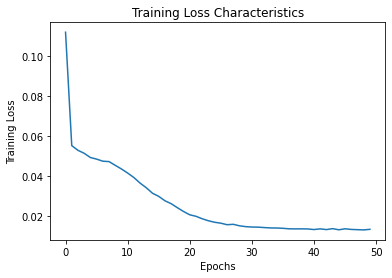

In [22]:
# Plot to visualize training loss
plt.plot(traiPrecisionn_loss_tnn)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Characteristics (Truth NN)')
plt.show()


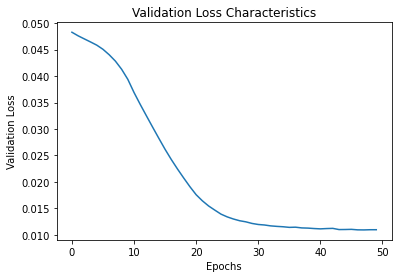

In [23]:
# Plot to visualize validation loss
plt.plot(val_loss_tnn)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Characteristics (Truth NN)')
plt.show()

In [0]:
# Using Truth NN to get classification on training set
ytrain_pred_tnn = TNN(torch.tensor(xtrain).float()).detach().numpy()
ytrain_pred_tnn = mat_normalize(ytrain_pred_tnn)

(array([1.00000e+00, 4.00000e+00, 1.50000e+01, 3.30000e+01, 1.28000e+02,
        5.97000e+02, 5.82200e+03, 7.44820e+04, 1.17694e+05, 2.22940e+04,
        4.67000e+03, 1.18600e+03, 4.20000e+02, 6.60000e+01, 3.90000e+01,
        8.80000e+01, 5.40000e+01, 8.90000e+01, 1.19000e+02, 4.40000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

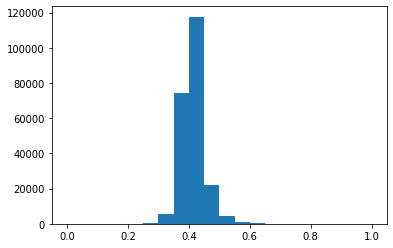

In [25]:
plt.hist(ytrain_pred_tnn, bins=20)

In [0]:
# Adjusting predictions to get binary output
ytrain_pred_tnn [ytrain_pred_tnn>=0.5] =1.0
ytrain_pred_tnn [ytrain_pred_tnn<0.5] =0.0

In [27]:
# Confusion matrix to visualize "TP", "FP", "TN", "FN"
#
# [TN FP]
# [FN TP]
print('Confusion matrix: {}'. format(metrics.confusion_matrix(ytrain, ytrain_pred_tnn, labels=[0, 1])))

Confusion matrix: [[221027   6427]
 [    43    348]]


In [28]:
# M_tnn = Misclassified samples using Truth NN
comb_tnn = ytrain_pred_tnn - ytrain
M_tnn = np.where(comb_tnn == 1)
M_tnn = list(M_tnn[0])
print(len(M_tnn))

6427


### Falsity Network

In [0]:
# Preparing complement targets for "Falsity NN"
ytrain_fnn = 1-ytrain
ytest_fnn = 1-ytest

In [0]:
# Creating Torch dataset for training Falsity NN
train_ds_fnn = torch.utils.data.TensorDataset(torch.tensor(xtrain).float(), torch.tensor(ytrain_fnn).float())
valid_ds_fnn = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest_fnn).float())


In [0]:
# Creating Torch dataloader for training Falsity NN
bs =128 # Batch Size
train_dl_fnn = torch.utils.data.DataLoader(train_ds_fnn, batch_size=bs)
valid_dl_fnn = torch.utils.data.DataLoader(valid_ds_fnn, batch_size=bs)


In [0]:
# Static Model Parameters
n_input = xtrain.shape[1]
n_output = 1
n_hidden = 20

In [0]:
# Initializing the "Falsity NN" model
FNN = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

In [0]:
# Static Training Parameters
lr = 0.005   # Learning Rate
pos_weight = torch.tensor([1/5])  # weight adjustment for class imbalance
opt = torch.optim.SGD(FNN.parameters(), lr=lr, momentum=0.9) #Optimizer
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)  #Loss function
#loss_func = torch.nn.BCEWithLogitsLoss()
#loss_func = torch.nn.BCELoss()
n_epoch = 50  # No. of epochs to run training

In [35]:
# Start Training
train_loss_fnn, val_loss_fnn = train(n_epoch,FNN,loss_func,opt,train_dl_fnn,valid_dl_fnn)


0 0.009516777596459004
1 0.009370766913417823
2 0.009218396570443982
3 0.009064201560133165
4 0.00887787435395902
5 0.008669223167907135
6 0.008402078679156297
7 0.008085046791190029
8 0.007706076504918443
9 0.007266204407402862
10 0.006867567184971745
11 0.006473070583165153
12 0.006089173537171156
13 0.005695032942447939
14 0.0053159838134714844
15 0.004975331693886305
16 0.00467847127071751
17 0.004412375358718873
18 0.004178460403838638
19 0.0039729038477379205
20 0.0038006054188517006
21 0.0036500341154246546
22 0.003505360904443486
23 0.0033828470068920625
24 0.003282577526830072
25 0.0031756394709912955
26 0.0030922331030438445
27 0.003009063038807708
28 0.0029386090516840364
29 0.002877829865194537
30 0.002799944042787108
31 0.0027566280466841155
32 0.0027112690115635163
33 0.002654913158327218
34 0.002604218410378519
35 0.0025665800174078115
36 0.002547318062987569
37 0.002506084092232007
38 0.0024739028281883144
39 0.002459699942421174
40 0.00243333403601688
41 0.002404943953

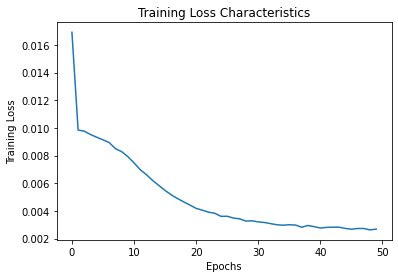

In [36]:
# Plot to visualize training loss
plt.plot(train_loss_fnn)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Characteristics (Falsity NN)')
plt.show()


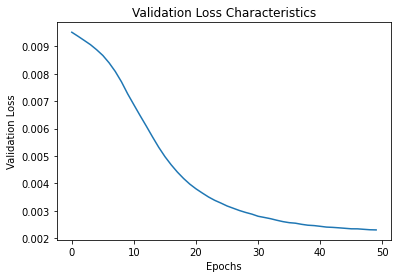

In [37]:
# Plot to visualize validation loss
plt.plot(val_loss_fnn)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Characteristics (Falsity NN)')
plt.show()

In [0]:
# Using the Falsity NN to get misclassified samples
ytrain_pred_fnn = FNN(torch.tensor(xtrain).float()).detach().numpy()
ytrain_pred_fnn = mat_normalize(ytrain_pred_fnn)

(array([3.4900e+02, 5.5000e+01, 3.5000e+01, 6.6000e+01, 3.0200e+02,
        7.9400e+02, 2.3080e+03, 9.3670e+03, 3.7195e+04, 8.0717e+04,
        6.9977e+04, 2.2390e+04, 3.4070e+03, 6.3400e+02, 1.6300e+02,
        4.3000e+01, 2.2000e+01, 1.5000e+01, 3.0000e+00, 3.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

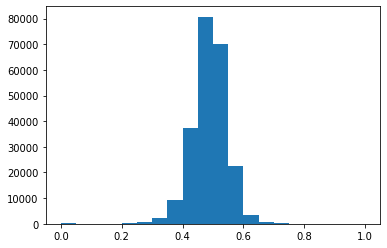

In [40]:
plt.hist(ytrain_pred_fnn, bins=20)

In [0]:
# Adjusting the predictions to output binary predictions
ytrain_pred_fnn [ytrain_pred_fnn>=0.5] =1.0
ytrain_pred_fnn [ytrain_pred_fnn<0.5] =0.0

In [42]:
# Confusion matrix to visualize "TP", "FP", "TN", "FN"
#
# [TN FP]
# [FN TP]
print('Confusion matrix: {}'. format(metrics.confusion_matrix(ytrain_fnn, ytrain_pred_fnn, labels=[0, 1])))

Confusion matrix: [[   385      6]
 [130803  96651]]


In [43]:
#M_fnn = List of samples misclassified by Falsity NN 
comb_fnn = ytrain_fnn - ytrain_pred_fnn
M_fnn = np.where(comb_fnn == 1)
M_fnn = list(M_fnn[0])
print(len(M_fnn))

130803


### Combining Truth and Falsity networks

In [0]:
M_intersection = list(set(M_fnn).intersection(M_tnn))
M_union = list(set(M_fnn).union(M_tnn))

In [45]:
print(len(M_union))
print(len(M_intersection))

130803
6427


In [46]:
# Finally removing the union of misclassified samples under-sample majority class
# Please note that the minority class samples are left untouched
xtrain_cm = np.delete(xtrain, M_union, axis=0)
ytrain_cm = np.delete(ytrain, M_union, axis=0)
print('Train dataset shape after CMTNN %s' % Counter(ytrain_cm))

Train dataset shape after CMTNN Counter({0: 96651, 1: 391})


## SMOTE

In [48]:
# Using SMOTE(Applied on the training set only) to over-sample the minority class
sm = SMOTE(random_state = 1)
xtrain_cm_sm, ytrain_cm_sm = sm.fit_sample(xtrain_cm, ytrain_cm.ravel()) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
print('Resampled train dataset shape %s' % Counter(ytrain_cm_sm))
print('Resampled validation dataset shape %s' % Counter(ytest))

Resampled train dataset shape Counter({0: 96651, 1: 96651})
Resampled validation dataset shape Counter({0: 56861, 1: 101})


##ANN without CMTNN and SMOTE

In [0]:
# Creating Torch dataset for training
train_ds = torch.utils.data.TensorDataset(torch.tensor(xtrain).float(), torch.tensor(ytrain).float())
valid_ds = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest).float())


In [0]:
# Creating Torch dataloader for training
bs =128 # Batch Size
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs)


In [0]:
# Static Model Parameters
n_input = xtrain.shape[1]
n_output = 1
n_hidden = 20

In [0]:
# Initializing the model
model = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

In [0]:
# Static Training Parameters
lr = 0.005   # Learning Rate
pos_weight = torch.tensor([5])  # weight adjustment for class imbalance
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #Optimizer
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)  #Loss function
n_epoch = 50  # No. of epochs to run training

In [55]:
# Start Training
train_loss, val_loss = train(n_epoch,model,loss_func,opt,train_dl,valid_dl)


0 0.04738517967964264
1 0.044029519642585155
2 0.0376277813742006
3 0.02986717402426481
4 0.0244203014222429
5 0.020209173102303673
6 0.01615367810075142
7 0.014103106560279662
8 0.012534949000240615
9 0.01189501877978906
10 0.011365876473937157
11 0.011569773979553836
12 0.010949422803463709
13 0.011036680341562166
14 0.010878071643846104
15 0.010660438693761366
16 0.010713874816838026
17 0.010797842927134517
18 0.011023297643015665
19 0.010496889098043593
20 0.010446751459824528
21 0.010539215952885218
22 0.010710050327164006
23 0.010435897519358181
24 0.011103845008536674
25 0.01053135105842687
26 0.01035473040828569
27 0.010408542352083347
28 0.01044467365506082
29 0.010303938832966021
30 0.010430449714784035
31 0.010340868108795163
32 0.010509685676750652
33 0.010355526914094205
34 0.01028887622103125
35 0.01032466481312796
36 0.010617004070006028
37 0.010290491958606412
38 0.01022382467367258
39 0.010166973102662399
40 0.010166322404671694
41 0.010622463763567978
42 0.01014169437

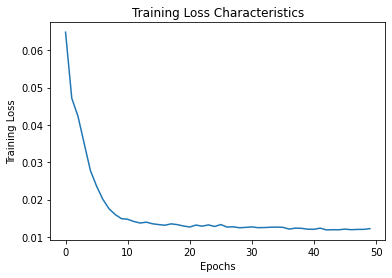

In [56]:
# Plot to visualize training loss
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Characteristics')
plt.show()


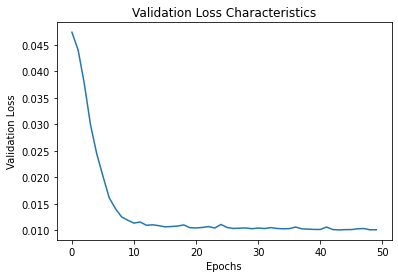

In [57]:
# Plot to visualize validation loss
plt.plot(val_loss)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Characteristics')
plt.show()

In [0]:
# Using the trained model for prediction
ypred = model(torch.tensor(xtest).float()).detach().numpy()
ypred = mat_normalize(ypred)
ypred [ypred>=0.5] =1.0
ypred [ypred<0.5] =0.0

In [59]:
# Confusion matrix to visualize "TP", "FP", "TN", "FN"
#
# [TN FP]
# [FN TP]
print(pos_weight)
print('Confusion matrix: {}'. format(metrics.confusion_matrix(ytest, ypred, labels=[0, 1])))

tensor([5])
Confusion matrix: [[43385 13476]
 [    3    98]]


In [60]:
# Area Under "Precision-Recall Curve"
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))

AUPRC score: 0.007057905301455482


In [61]:
# Area Under "ROC Curve" [ROC: Reciever-OPerating Characteristics (TP vs FP)]
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))

AUROC score: 0.866649016073764


In [62]:
# Accuracy of the model
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))

Accuracy score: 0.7633685614971385


In [63]:
print(metrics.classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       1.00      0.76      0.87     56861
           1       0.01      0.97      0.01       101

    accuracy                           0.76     56962
   macro avg       0.50      0.87      0.44     56962
weighted avg       1.00      0.76      0.86     56962



## ANN With CMTNN and SMOTE

In [0]:
# Creating Torch dataset for training
train_ds_cm_sm = torch.utils.data.TensorDataset(torch.tensor(xtrain_cm_sm).float(), torch.tensor(ytrain_cm_sm).float())
valid_ds = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest).float())


In [0]:
# Creating Torch data loader service for training
bs =128 # Batch Size
train_dl_cm_sm = torch.utils.data.DataLoader(train_ds_cm_sm, batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs)


In [0]:
# Static Model Parameters
n_input = xtrain.shape[1]
n_output = 1
n_hidden = 20

In [0]:
# Model Initialization
model_cm_sm = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

In [0]:
# Static Training Parameters
lr = 0.001   # Learning Rate
opt = torch.optim.SGD(model_cm_sm.parameters(), lr=lr, momentum=0.9) #Optimizer
loss_func_over = torch.nn.BCEWithLogitsLoss() # Loss function to be used for training
n_epoch = 500  # No. of epochs to run 
#(We can afford higher epochs  beacuse we have reduced our dataset size by CMTNN )

In [69]:
# Starting Model Training
train_loss_cm_sm, val_loss_cm_sm = train(n_epoch,model_cm_sm,loss_func_over,opt,train_dl_cm_sm,valid_dl)


0 5.299412363479028
1 5.547577694013946
2 5.537607941708368
3 5.461697536507482
4 5.388870834345764
5 5.302655298017324
6 5.200961687471009
7 5.096765222385699
8 5.008742536848371
9 4.916896975704686
10 4.839882974138103
11 4.773436292931126
12 4.710518840624917
13 4.6607001823536995
14 4.612166970864654
15 4.562674503464373
16 4.519244703130313
17 4.484704610265995
18 4.461976610874637
19 4.42163093702574
20 4.3992613312953734
21 4.373683558752319
22 4.347809663151578
23 4.32533664875145
24 4.310822434959601
25 4.302511688866084
26 4.276162242082426
27 4.258755628649369
28 4.2570881244527765
29 4.227832627804577
30 4.220167845932312
31 4.2072571158714664
32 4.200571178632365
33 4.196642928861642
34 4.185780762211375
35 4.172261804422842
36 4.153180587241909
37 4.140030798016838
38 4.143722618954272
39 4.132523597038084
40 4.141359303775352
41 4.139750271515541
42 4.125402107863592
43 4.117471150922322
44 4.119855475825024
45 4.121157573710198
46 4.110493592250582
47 4.1281056947066235

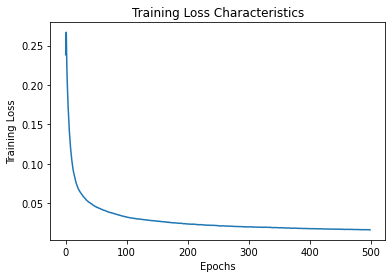

In [70]:
# Plotting Training Loss Characteristics
plt.plot(train_loss_cm_sm)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Characteristics')
plt.show()

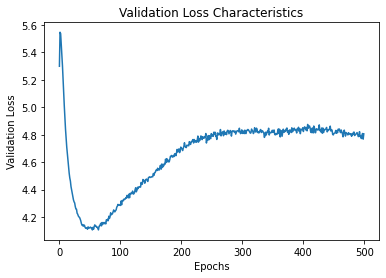

In [71]:
# Plotting Validation Loss Characteristics
plt.plot(val_loss_cm_sm)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Characteristics')
plt.show()

(array([3.3000e+01, 8.6200e+02, 3.3998e+04, 1.9334e+04, 2.6030e+03,
        7.3000e+01, 2.0000e+01, 1.7000e+01, 1.2000e+01, 1.0000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

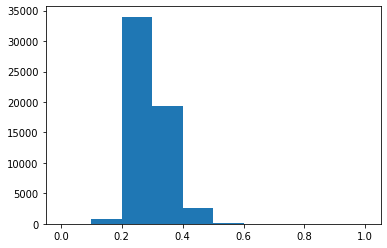

In [72]:
# Using our trained model to predict fraudulent transactions
ypred_cm_sm = model_cm_sm(torch.tensor(xtest).float()).detach().numpy()
ypred_cm_sm = mat_normalize(ypred_cm_sm)
plt.hist(ypred_cm_sm)


In [0]:
# Adjusting the predicted values to get binary outputs
ypred_cm_sm [ypred_cm_sm>=0.5] =1.0
ypred_cm_sm [ypred_cm_sm<0.5] =0.0

In [74]:
# Confusion matrix to visualize "TP", "FP", "TN", "FN"
#
# [TN FP]
# [FN TP]
print('Confusion matrix: {}'. format(metrics.confusion_matrix(ytest, ypred_cm_sm)))

Confusion matrix: [[56805    56]
 [   25    76]]


In [75]:
# Area under "Precision-Recall Curve"
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred_cm_sm)))

AUPRC score: 0.43368221341638397


In [76]:
# Area under "ROC Curve" [ROC: Reciever Operating Characteristics (TP vs FP)]
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred_cm_sm)))

AUROC score: 0.8757451948567995


In [77]:
# Accuracy of the Model
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred_cm_sm)))

Accuracy score: 0.9985779993679997


In [78]:
print(metrics.classification_report(ytest, ypred_cm_sm))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.58      0.75      0.65       101

    accuracy                           1.00     56962
   macro avg       0.79      0.88      0.83     56962
weighted avg       1.00      1.00      1.00     56962



## Conclusion: [As noted on 8 April]





1.   While the overall accuracy after using only SMOTE was reduced(earlier experiment), we can see that using CMTNN + SMOTE results in increased accuracy .

2. Accuracy increased: 97.2% ==> 99.8%

3. Precision(fraudulent class) increased: 0.01 ==> 0.58

4. F1 score(fraudulent class) increased: 0.01 ==> 0.65

5.   While applying SMOTE we increase the no. of samples for the minority class. But in this case the minority class is only 0.17% and thus increasing the minority class samples alone would put too much stress on the SMOTE algorithm. Therefore we have made use of CMTNN + SMOTE.
Applying CMTNN first helps us to extract training examples which contain more information( *and thus are more useful in training*)

